# Experiments on recording settings (i.e, the Inputs)

1. On Velocity Magnitude $|\mathbf{v}|$ and Orientation $\theta$  
2. On Particle Diameter $d_\tau$
3. On Particle Density $\rho$

## 0. Fundamental Functions

In [1]:
import cv2
import numpy as np
import torch

from tqdm.notebook import tqdm
from addict import Dict

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.font_manager import FontProperties
import seaborn as sns

from generator.flow import FlowManager 
from generator.loader import config_events as config
from generator.loader import EventManager
# from utils.spliter import split_events_voxelized
from kernels.pcm import estimatePCM,objective2d_origin,objective2d_smooth

from utils.visualizer import plot_event_time2d


stsong_font = FontProperties(fname=None, family='STSong')

cmap = mpl.colormaps['tab10']
colors = cmap(np.linspace(0, 1, 10))
colors = np.concatenate([colors]*10,axis=0)
markers = ["s", "^", ">", "o", "*", "v", "<", "P", "X", "D"]*10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

torch.manual_seed(100) # the same seed for the reproducible results

# Test_mode_flag = True
Test_mode_flag = False

cuda:0


In [2]:
def default_config():
    cfg = config()
    
    # images
    cfg.density = 0.05
    cfg.width = 256
    cfg.height = 256
    cfg.d = 1.0
    cfg.d_std = 0.2
    cfg.l = 200
    cfg.l_std = 10

    # events generation
    cfg.time_length = 4
    cfg.threshold = 0.25 # the constant fire threshold

    # flow field (uniform flow)
    cfg.amp = 2.5
    cfg.theta = 0.0

    # noise ratio (change the evts to random values)
    cfg.ratio = 0.001 
   
    # spliter
    cfg.x_span = 33
    cfg.y_span = 33
    cfg.H, cfg.W = 256, 256
    cfg.step = 24
    cfg.t_min = 0.5
    cfg.t_max = 3.5

    # algorithm
    cfg.sigma2_min = 1.0
    return cfg

In [3]:
import torch
from utils.spliter import filter_events_by_time_polarity, EventSpatialSplitter

def evaluate_at_cfg(cfg):
    # === 1. 构造真实速度向量 ===
    u, v = cfg.amp * np.cos(cfg.theta), cfg.amp * np.sin(cfg.theta)
    true_velocity = torch.tensor([[u, v]], device=device)  # (1, 2)

    # === 2. 构造模拟流场 ===
    flow_generator = FlowManager(mode="analytical", name="uniform", uc=u, vc=v)
    flow_func = flow_generator.evaluate

    # === 3. 生成事件数据 ===
    case = Dict(source_type="simulator", path=None, cfg=cfg, flow_func=flow_func)
    event_loader = EventManager(**case)
    evts_all, _ = event_loader.load()
    evts_all = evts_all.to(device)

    # === 4. 按空间+时间切块（使用体素方式） ===
    evts = filter_events_by_time_polarity(evts_all, t_min=cfg.t_min, t_max=cfg.t_max, polarity=1)

    # == 添加噪声
    if cfg.ratio>0:
         # 计算需要替换的事件数量
        B = evts.shape[0]
        num_noise = int(B * cfg.ratio)
        # 随机选择要替换的事件索引
        indices = torch.randperm(B)[:num_noise]
        
        # 生成随机坐标 (x, y)
        x_rand = torch.randint(0, cfg.height, (num_noise,), device=evts.device, dtype=evts.dtype)
        y_rand = torch.randint(0, cfg.width, (num_noise,), device=evts.device, dtype=evts.dtype)
        evts[indices, 0] = x_rand
        evts[indices, 1] = y_rand

    spliter = EventSpatialSplitter(cfg)
    spliter.put_data(evts)

    # === 5. 对每个块进行速度估计并记录 ===
    v_ests = []
    for px in torch.arange(16, cfg.H, cfg.step):
        for py in torch.arange(16, cfg.W, cfg.step):
            block = spliter.obtain_at(px, py)
            if len(block) < 300:
                continue

            # v_est, _ = estimatePCM(block[:2000], objective2d=objective2d_smooth, sigma2_min=cfg.sigma2_min)
            v_est, _ = estimatePCM(block[:2500], objective2d=objective2d_smooth, sigma2_min=cfg.sigma2_min)
            v_ests.append(v_est)
            
    # === 6. 若无有效块，返回NaN ===
    if len(v_ests) == 0:
        return torch.tensor(float('nan')), torch.tensor(float('nan'))

    # === 7. 计算 RMSE 和 AEE ===
    v_ests_tensor = torch.stack(v_ests, dim=0)  # (B, 2)
    bias_error = v_ests_tensor - true_velocity  # (B, 2)
    epe_tensor = torch.norm(bias_error, dim=1)  # 每个块的端点误差 EPE

    rmse = torch.sqrt(torch.mean(epe_tensor ** 2))
    aee = torch.mean(epe_tensor)
    return rmse, aee

def exp_template(name1, val1, name2, val2):
    # === 初始化配置 ===
    cfg = default_config()

    # === 创建结果存储数组 ===
    rmses = np.zeros((len(val1), len(val2)))
    aees  = np.zeros((len(val1), len(val2)))

    # === 遍历两个参数组合 ===
    for i, v1 in enumerate(tqdm(val1, desc=f"Scanning {name1}")):
        # for j, v2 in enumerate(tqdm(val2, desc=f"  ↳ {name2} at {name1}={v1}", leave=False)):
        for j, v2 in enumerate(val2):
            cfg[name1] = v1  # set new config
            cfg[name2] = v2
            rmse, aee = evaluate_at_cfg(cfg)
            rmses[i, j] = rmse
            aees[i, j]  = aee

    return rmses, aees

rmses, aees = exp_template('amp',[3.0], 'theta',[0.02])
print(rmses)
print(aees)

Scanning amp:   0%|          | 0/1 [00:00<?, ?it/s]

[[0.01112921]]
[[0.00884606]]


In [4]:
def plots(thetas_degree, errors, labels, errortype='RMSE', name="Mag", ylim = [-0.01, 0.21]):
    # display the results
    plt.figure(figsize=(5,3))
    for i, _ in enumerate(labels): 
        plt.plot(thetas_degree, errors[:,i], color=colors[i+1], marker=markers[i], markevery=4, label=labels[i])
    plt.legend(loc=1)
    # plt.yscale('log')
    
    plt.xlim([np.min(thetas_degree)-0.1, np.max(thetas_degree)+0.1])
    # plt.ylim([1e-3, 0.5])
    plt.ylim(ylim)
    plt.grid(True)
    xticks_deg = np.linspace(0, 180, 9)
    plt.xticks(xticks_deg)
    
    # ===== 1. 中文标签并保存 =====
    plt.xlabel('速度方向 $\\theta$ [$^\circ$]', fontproperties=stsong_font)
    if errortype == 'RMSE':
        plt.ylabel('均方根误差 $[px/ms]$', fontproperties=stsong_font)
    else:
        plt.ylabel('均方根误差 $[px/ms]$', fontproperties=stsong_font)
    plt.savefig(f"output/Fig2_{name}_{errortype}_zh.pdf")
    
    # ===== 2. 英文标签并保存 =====
    # plt.xlabel('velocity $\\theta$ [$^\circ$]')
    plt.xlabel('Velocity orientation $\\theta$ [$^\circ$]')
    plt.ylabel('RMSE $[px/ms]$')
    if errortype == 'RMSE':
        plt.ylabel('RMSE $[px/ms]$')
    else:
        plt.ylabel('AEE $[px/ms]$')
    plt.savefig(f"output/Fig2_{name}_{errortype}.pdf")
    # ===== 3. 显示图像 =====
    plt.title("Estimation Error as a Function of $\\theta$ ")

## 1. On Velocity Magnitude $|\mathbf{v}|$ and Orientation $\theta$  

Scanning theta:   0%|          | 0/73 [00:00<?, ?it/s]

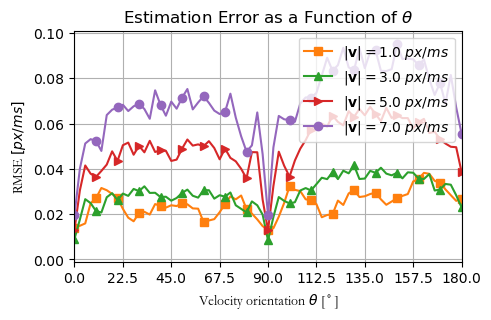

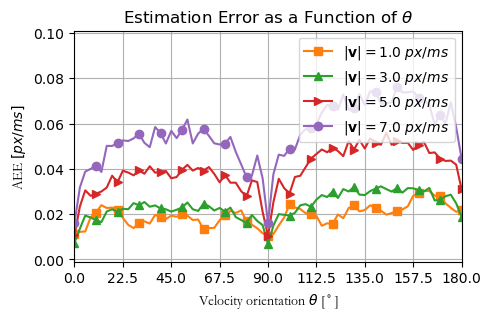

Font 'default' does not have a glyph for '\u6839' [U+6839], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6839' [U+6839], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6839' [U+6839], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6839' [U+6839], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


findfont: Font family 'STSong' not found.


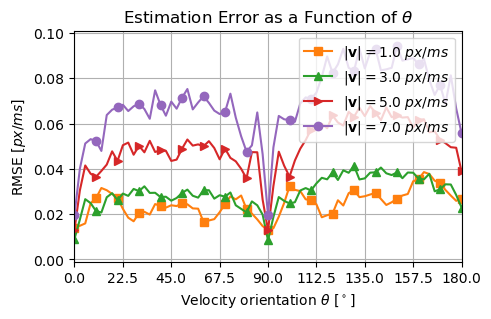

findfont: Font family 'STSong' not found.


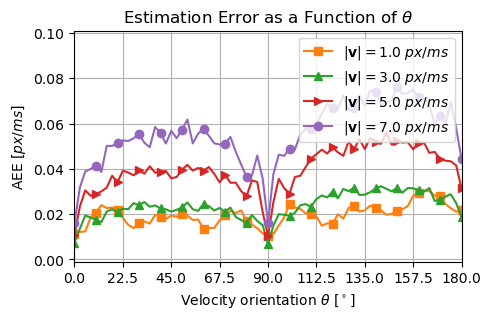

In [5]:
def exp_theta_amp(test = True):
    N = 9 if test else 73
    theta = np.linspace(0,np.pi,N) 
    thetas_degree = theta*180/np.pi

    vals = [1.0,3.0,5.0,7.0]
    labels = [f"$|\\mathbf{{v}}|=${vals[i]:3.1f} $px/ms$" for i in range(len(vals))]
    
    rmse, aee = exp_template('theta', theta, 'amp', vals)

    plots(thetas_degree, rmse, labels, errortype='RMSE', name="Amp", ylim = [-0.001, 0.101])
    plots(thetas_degree, aee, labels, errortype='AEE', name="Amp", ylim = [-0.001, 0.101])
    plt.show()

exp_theta_amp(test = Test_mode_flag)

## 2. On Particle Diameter $d_\tau$

Scanning theta:   0%|          | 0/73 [00:00<?, ?it/s]

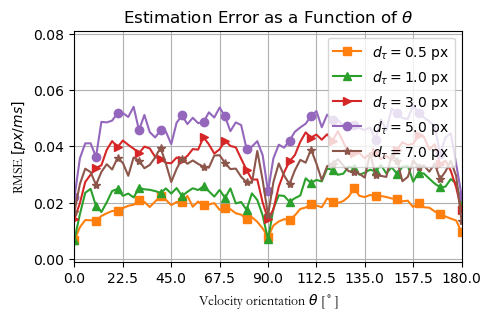

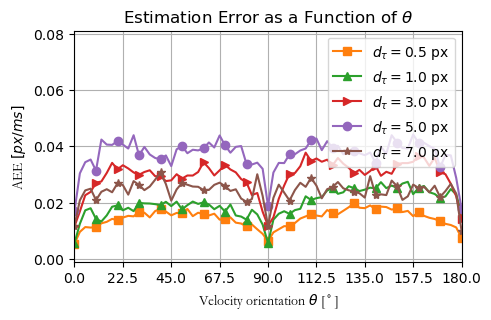

Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6839' [U+6839], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6839' [U+6839], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6839' [U+6839], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


findfont: Font family 'STSong' not found.


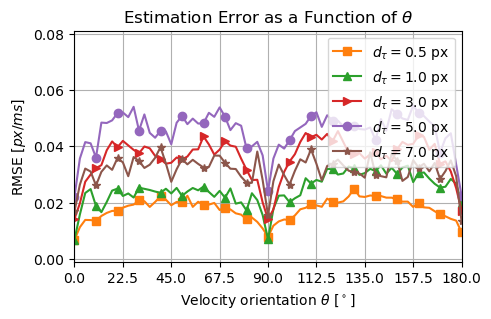

findfont: Font family 'STSong' not found.


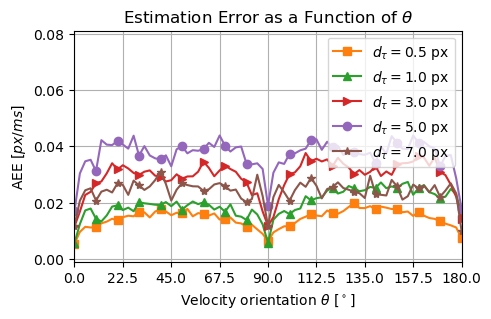

In [6]:
# on particle diameters
def exp_theta_diameter(test = True):
    N = 9 if test else 73
    theta = np.linspace(0,np.pi,N) 
    thetas_degree = theta*180/np.pi

    vals = [0.5, 1.0, 3.0, 5.0, 7.0]
    labels = [f"$d_\\tau=${vals[i]:3.1f} px" for i in range(len(vals))]
    
    rmse, aee = exp_template('theta', theta, 'd', vals)

    plots(thetas_degree, rmse, labels, errortype='RMSE', name="Diameter", ylim = [-0.001, 0.081])
    plots(thetas_degree, aee, labels, errortype='AEE', name="Diameter", ylim = [-0.001, 0.081])
    plt.show()

exp_theta_diameter(test = Test_mode_flag)

## 3. On Particle Density $\rho$

Scanning theta:   0%|          | 0/73 [00:00<?, ?it/s]

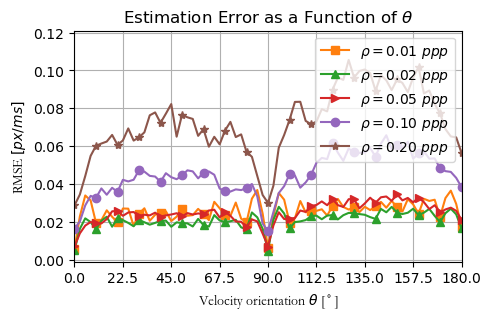

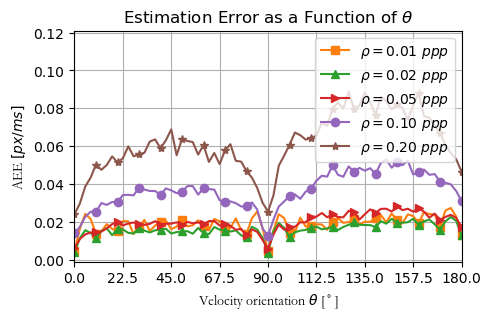

Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6839' [U+6839], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6839' [U+6839], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6839' [U+6839], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


findfont: Font family 'STSong' not found.


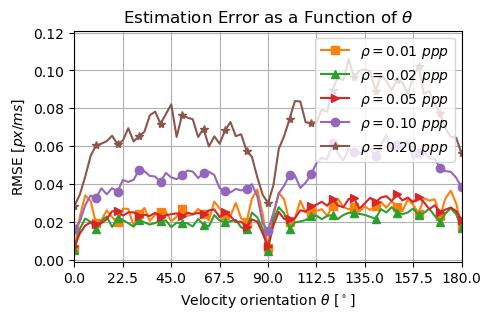

findfont: Font family 'STSong' not found.


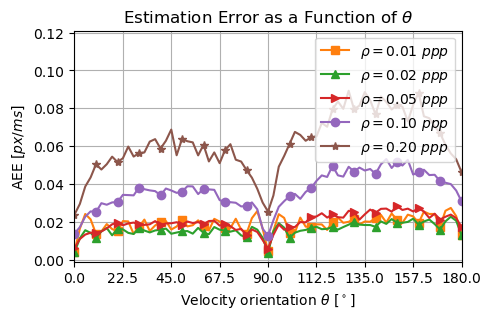

In [7]:
# on particle density
def exp_theta_density(test = True):
    N = 9 if test else 73
    theta = np.linspace(0,np.pi,N) 
    thetas_degree = theta*180/np.pi

    vals = [0.01, 0.02, 0.05, 0.1, 0.2]
    labels = [f"$\\rho=${vals[i]:3.2f} $ppp$ " for i in range(len(vals))]
    
    rmse, aee = exp_template('theta', theta, 'density', vals)

    plots(thetas_degree, rmse, labels, errortype='RMSE', name="density", ylim = [-0.001, 0.121])
    plots(thetas_degree, aee, labels, errortype='AEE', name="density", ylim = [-0.001, 0.121])
    plt.show()

exp_theta_density(test = Test_mode_flag)

## 4. On noise ratio $R_{noise}$

Scanning theta:   0%|          | 0/73 [00:00<?, ?it/s]

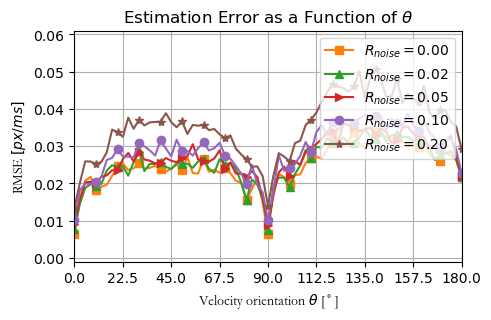

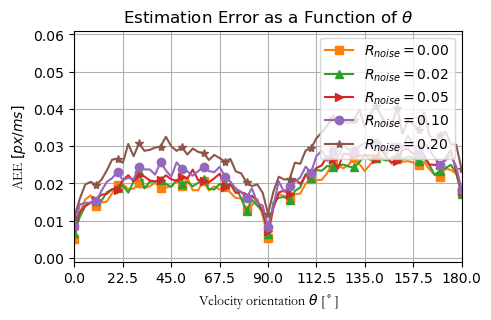

Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6839' [U+6839], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6839' [U+6839], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


Font 'default' does not have a glyph for '\u901f' [U+901f], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5ea6' [U+5ea6], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5411' [U+5411], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5747' [U+5747], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u65b9' [U+65b9], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u6839' [U+6839], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u8bef' [U+8bef], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.


findfont: Font family 'STSong' not found.


findfont: Font family 'STSong' not found.


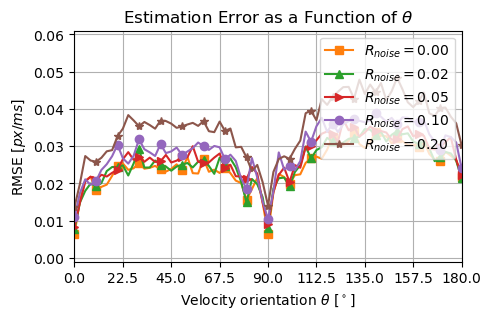

findfont: Font family 'STSong' not found.


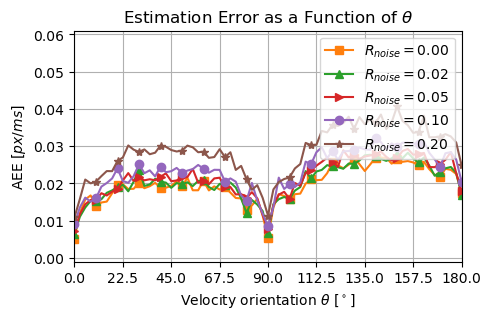

In [8]:
# on outlier events noise ratio
def exp_theta_noise(test = True):
    N = 9 if test else 73
    theta = np.linspace(0,np.pi,N) 
    thetas_degree = theta*180/np.pi

    vals = [0.0, 0.02, 0.05, 0.10, 0.20]
    labels = [f"$R_{{noise}}=${vals[i]:3.2f}" for i in range(len(vals))]
    
    rmse, aee = exp_template('theta', theta, 'ratio', vals)

    plots(thetas_degree, rmse, labels, errortype='RMSE', name="noise",ylim=[-0.001, 0.061])
    plots(thetas_degree, aee, labels, errortype='AEE', name="noise",ylim=[-0.001, 0.061])
    plt.show()

exp_theta_noise(test = Test_mode_flag)